In [16]:
# check sample data
import pandas as pd
df = pd.read_csv("sample.csv",index_col=0)
# df.drop(columns=[""])
df  = df.drop(columns=["Patient"])
df.columns = ["S", "A", "P", "CDR"]
df

,S,A,P,CDR
10,came with daughter and an attendant; on ng; on...,trouble sleeping; reluctant to talk while ques...,opd follow-up,3.0
17,NaN,mild dementia --> moderate cdr = 1 --> 2 「身障」1...,arrange psychological for revise disability ad...,1.0
23,"2021/1/2, -ill-defined sensation in the bilate...",neck and low back pain -dm polyneuropathy -old...,monitor blood pressure and blood glucose at ho...,1.0
24,"stable; pureed food 2020/12/3, loss follow-up ...","-ad (onset: 2016; 2020/12/22, cdr=2) -head inj...",switch aricept to witgen (2021/1) advise check...,2.0
25,20210104 left lower limb soreness ask for bloo...,============== lately pedal edema bilat. and m...,advised record of blood pressure . tapping of ...,0.5
27,insidious onset of memory impairment for 3+ ye...,"dementia syndrome, casi:36, (mmse:8-11/30) cdr...","avoid stilnox, cdr:0.5 --> 1 (not indicated 殘鑑...",0.5
29,live in care unit 109.11.17: recent memory imp...,"r/o dementia (cdr:1 109/11 psy-opd), upload he...",monitor noopol effect inform drug side effect ...,1.0
30,insidous onset of memory impairment for 2+ yea...,1. head injury with sah and ich 2. dementia sy...,seroquel asked for mental check up for legal p...,1.0
31,insidious onset of memory impairment for 5+ ye...,1. dementia syndroem r/o alzheimer`s disese cd...,"mmse: 19 cdr: 1 brain ct; mild atrophy , bil t...",1.0
35,20201112- home visit. 1091027: oxynorm還有; 有時會痛...,"r/o vascular dementia with vh (cdr:0.5, npi>30...",bpsd improved well educated vascular dementia ...,0.5


In [9]:
# fine tune (retrain) BERT & bioBERT
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# choose task type：'classification' or 'regression'
task_type = "classification"  # or "regression"

# load pretrained BERT 
model_name = "dmis-lab/biobert-base-cased-v1.1"
num_labels = 5 if task_type == "classification" else 1  # if we have 5 types in CDR
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels, 
    problem_type="regression" if task_type == "regression" else "single_label_classification"
)

# read dataset
df = pd.read_csv("1yr_train.csv")

# preprocecss the data to (text,label)
def preprocess_data(row):
    text = f"{row['S']} [SEP] {row['A']} [SEP] {row['P']}"
    label_map = {0: 0, 0.5: 1, 1: 2, 2: 3, 3: 4}
    mapped_label = label_map[row['CDR']]
    return {"text": text, "label": mapped_label}

processed_data = df.apply(preprocess_data, axis=1).to_list()
dataset = Dataset.from_list(processed_data)

# tokenize 
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# set data format
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

# train-val divide
split = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = split["train"]
eval_dataset = split["test"]

# Trainer
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

# train
trainer.train()

# save the trained model
model.save_pretrained("./bert-cdr-model")
tokenizer.save_pretrained("./bert-cdr-model")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 2599/2599 [00:03<00:00, 799.58 examples/s] 
d:\CodingEnvs\ANACONDA\envs\6893\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\chenf\AppData\Local\Temp\ipykernel_58448\849632614.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  1%|▏         | 10/780 [00:05<06:24,  2.00it/s]

{'loss': 1.5785, 'grad_norm': 7.663490295410156, 'learning_rate': 1.9743589743589745e-05, 'epoch': 0.04}


  3%|▎         | 20/780 [00:10<06:22,  1.99it/s]

{'loss': 1.331, 'grad_norm': 4.735093593597412, 'learning_rate': 1.9487179487179488e-05, 'epoch': 0.08}


  4%|▍         | 30/780 [00:15<06:19,  1.98it/s]

{'loss': 1.4429, 'grad_norm': 8.842818260192871, 'learning_rate': 1.923076923076923e-05, 'epoch': 0.12}


  5%|▌         | 40/780 [00:20<06:18,  1.96it/s]

{'loss': 1.3911, 'grad_norm': 10.134134292602539, 'learning_rate': 1.8974358974358975e-05, 'epoch': 0.15}


  6%|▋         | 50/780 [00:25<06:16,  1.94it/s]

{'loss': 1.4336, 'grad_norm': 9.549099922180176, 'learning_rate': 1.8717948717948718e-05, 'epoch': 0.19}


  8%|▊         | 60/780 [00:30<06:13,  1.93it/s]

{'loss': 1.264, 'grad_norm': 5.908236980438232, 'learning_rate': 1.8461538461538465e-05, 'epoch': 0.23}


  9%|▉         | 70/780 [00:36<06:54,  1.71it/s]

{'loss': 1.3841, 'grad_norm': 6.8313093185424805, 'learning_rate': 1.8205128205128208e-05, 'epoch': 0.27}


 10%|█         | 80/780 [00:42<07:16,  1.60it/s]

{'loss': 1.3228, 'grad_norm': 14.534529685974121, 'learning_rate': 1.794871794871795e-05, 'epoch': 0.31}


 12%|█▏        | 90/780 [00:48<07:13,  1.59it/s]

{'loss': 1.4309, 'grad_norm': 3.4351871013641357, 'learning_rate': 1.7692307692307694e-05, 'epoch': 0.35}


 13%|█▎        | 100/780 [00:54<07:08,  1.59it/s]

{'loss': 1.3131, 'grad_norm': 5.104325294494629, 'learning_rate': 1.7435897435897438e-05, 'epoch': 0.38}


 14%|█▍        | 110/780 [01:01<07:02,  1.59it/s]

{'loss': 1.3251, 'grad_norm': 10.102885246276855, 'learning_rate': 1.717948717948718e-05, 'epoch': 0.42}


 15%|█▌        | 120/780 [01:07<06:54,  1.59it/s]

{'loss': 1.2399, 'grad_norm': 5.908056735992432, 'learning_rate': 1.6923076923076924e-05, 'epoch': 0.46}


 17%|█▋        | 130/780 [01:13<06:46,  1.60it/s]

{'loss': 1.2096, 'grad_norm': 4.949821949005127, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.5}


 18%|█▊        | 140/780 [01:20<06:44,  1.58it/s]

{'loss': 1.3136, 'grad_norm': 11.377449035644531, 'learning_rate': 1.641025641025641e-05, 'epoch': 0.54}


 19%|█▉        | 150/780 [01:26<06:37,  1.59it/s]

{'loss': 1.1959, 'grad_norm': 5.751267910003662, 'learning_rate': 1.6153846153846154e-05, 'epoch': 0.58}


 21%|██        | 160/780 [01:32<06:30,  1.59it/s]

{'loss': 1.2597, 'grad_norm': 8.945658683776855, 'learning_rate': 1.5897435897435897e-05, 'epoch': 0.62}


 22%|██▏       | 170/780 [01:39<06:22,  1.59it/s]

{'loss': 1.3272, 'grad_norm': 7.879946231842041, 'learning_rate': 1.5641025641025644e-05, 'epoch': 0.65}


 23%|██▎       | 180/780 [01:45<06:16,  1.59it/s]

{'loss': 1.2184, 'grad_norm': 8.924969673156738, 'learning_rate': 1.5384615384615387e-05, 'epoch': 0.69}


 24%|██▍       | 190/780 [01:51<06:11,  1.59it/s]

{'loss': 1.2989, 'grad_norm': 9.450664520263672, 'learning_rate': 1.5128205128205129e-05, 'epoch': 0.73}


 26%|██▌       | 200/780 [01:57<06:06,  1.58it/s]

{'loss': 1.2836, 'grad_norm': 6.00681209564209, 'learning_rate': 1.4871794871794874e-05, 'epoch': 0.77}


 27%|██▋       | 210/780 [02:04<06:01,  1.58it/s]

{'loss': 1.2488, 'grad_norm': 10.188304901123047, 'learning_rate': 1.4615384615384615e-05, 'epoch': 0.81}


 28%|██▊       | 220/780 [02:10<05:54,  1.58it/s]

{'loss': 1.2367, 'grad_norm': 6.634196758270264, 'learning_rate': 1.435897435897436e-05, 'epoch': 0.85}


 29%|██▉       | 230/780 [02:16<05:47,  1.58it/s]

{'loss': 1.2072, 'grad_norm': 9.84849739074707, 'learning_rate': 1.4102564102564105e-05, 'epoch': 0.88}


 31%|███       | 240/780 [02:23<05:43,  1.57it/s]

{'loss': 1.1844, 'grad_norm': 11.169960021972656, 'learning_rate': 1.3846153846153847e-05, 'epoch': 0.92}


 32%|███▏      | 250/780 [02:29<05:36,  1.58it/s]

{'loss': 1.136, 'grad_norm': 9.989754676818848, 'learning_rate': 1.3589743589743592e-05, 'epoch': 0.96}


 33%|███▎      | 260/780 [02:35<05:21,  1.62it/s]

{'loss': 1.1829, 'grad_norm': 11.016871452331543, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}



 33%|███▎      | 260/780 [02:46<05:21,  1.62it/s]

{'eval_loss': 1.1595405340194702, 'eval_runtime': 10.9087, 'eval_samples_per_second': 47.668, 'eval_steps_per_second': 5.959, 'epoch': 1.0}


 35%|███▍      | 270/780 [02:53<06:31,  1.30it/s]

{'loss': 0.964, 'grad_norm': 8.443071365356445, 'learning_rate': 1.3076923076923078e-05, 'epoch': 1.04}


 36%|███▌      | 280/780 [02:59<05:21,  1.56it/s]

{'loss': 1.0525, 'grad_norm': 8.916522979736328, 'learning_rate': 1.2820512820512823e-05, 'epoch': 1.08}


 37%|███▋      | 290/780 [03:06<05:11,  1.57it/s]

{'loss': 1.0927, 'grad_norm': 10.854117393493652, 'learning_rate': 1.2564102564102565e-05, 'epoch': 1.12}


 38%|███▊      | 300/780 [03:12<05:06,  1.57it/s]

{'loss': 1.0968, 'grad_norm': 8.605643272399902, 'learning_rate': 1.230769230769231e-05, 'epoch': 1.15}


 40%|███▉      | 310/780 [03:18<04:56,  1.58it/s]

{'loss': 1.1398, 'grad_norm': 18.197786331176758, 'learning_rate': 1.2051282051282051e-05, 'epoch': 1.19}


 41%|████      | 320/780 [03:25<04:52,  1.57it/s]

{'loss': 1.1572, 'grad_norm': 6.5313401222229, 'learning_rate': 1.1794871794871796e-05, 'epoch': 1.23}


 42%|████▏     | 330/780 [03:31<04:46,  1.57it/s]

{'loss': 0.862, 'grad_norm': 8.349452018737793, 'learning_rate': 1.1538461538461538e-05, 'epoch': 1.27}


 44%|████▎     | 340/780 [03:37<04:39,  1.57it/s]

{'loss': 1.0338, 'grad_norm': 13.702668190002441, 'learning_rate': 1.1282051282051283e-05, 'epoch': 1.31}


 45%|████▍     | 350/780 [03:44<04:32,  1.58it/s]

{'loss': 0.8312, 'grad_norm': 11.839359283447266, 'learning_rate': 1.1025641025641028e-05, 'epoch': 1.35}


 46%|████▌     | 360/780 [03:50<04:26,  1.58it/s]

{'loss': 0.9243, 'grad_norm': 7.211650371551514, 'learning_rate': 1.076923076923077e-05, 'epoch': 1.38}


 47%|████▋     | 370/780 [03:56<04:19,  1.58it/s]

{'loss': 0.9566, 'grad_norm': 21.309988021850586, 'learning_rate': 1.0512820512820514e-05, 'epoch': 1.42}


 49%|████▊     | 380/780 [04:03<04:13,  1.58it/s]

{'loss': 1.0226, 'grad_norm': 10.894637107849121, 'learning_rate': 1.0256410256410256e-05, 'epoch': 1.46}


 50%|█████     | 390/780 [04:09<04:05,  1.59it/s]

{'loss': 0.9131, 'grad_norm': 11.009210586547852, 'learning_rate': 1e-05, 'epoch': 1.5}


 51%|█████▏    | 400/780 [04:15<04:01,  1.58it/s]

{'loss': 1.0241, 'grad_norm': 11.182087898254395, 'learning_rate': 9.743589743589744e-06, 'epoch': 1.54}


 53%|█████▎    | 410/780 [04:22<03:54,  1.58it/s]

{'loss': 0.9333, 'grad_norm': 17.965295791625977, 'learning_rate': 9.487179487179487e-06, 'epoch': 1.58}


 54%|█████▍    | 420/780 [04:28<03:47,  1.58it/s]

{'loss': 0.7757, 'grad_norm': 8.573456764221191, 'learning_rate': 9.230769230769232e-06, 'epoch': 1.62}


 55%|█████▌    | 430/780 [04:34<03:43,  1.57it/s]

{'loss': 0.9779, 'grad_norm': 9.324666023254395, 'learning_rate': 8.974358974358976e-06, 'epoch': 1.65}


 56%|█████▋    | 440/780 [04:41<03:37,  1.56it/s]

{'loss': 0.8362, 'grad_norm': 16.069385528564453, 'learning_rate': 8.717948717948719e-06, 'epoch': 1.69}


 58%|█████▊    | 450/780 [04:47<03:31,  1.56it/s]

{'loss': 0.9552, 'grad_norm': 12.57038688659668, 'learning_rate': 8.461538461538462e-06, 'epoch': 1.73}


 59%|█████▉    | 460/780 [04:53<03:22,  1.58it/s]

{'loss': 0.808, 'grad_norm': 7.974841594696045, 'learning_rate': 8.205128205128205e-06, 'epoch': 1.77}


 60%|██████    | 470/780 [05:00<03:18,  1.56it/s]

{'loss': 0.7227, 'grad_norm': 22.02729606628418, 'learning_rate': 7.948717948717949e-06, 'epoch': 1.81}


 62%|██████▏   | 480/780 [05:06<03:12,  1.56it/s]

{'loss': 0.8474, 'grad_norm': 12.520627975463867, 'learning_rate': 7.692307692307694e-06, 'epoch': 1.85}


 63%|██████▎   | 490/780 [05:13<03:04,  1.57it/s]

{'loss': 0.6745, 'grad_norm': 19.261117935180664, 'learning_rate': 7.435897435897437e-06, 'epoch': 1.88}


 64%|██████▍   | 500/780 [05:19<02:58,  1.57it/s]

{'loss': 0.8991, 'grad_norm': 13.63475227355957, 'learning_rate': 7.17948717948718e-06, 'epoch': 1.92}


 65%|██████▌   | 510/780 [05:28<03:00,  1.49it/s]

{'loss': 0.7405, 'grad_norm': 12.387992858886719, 'learning_rate': 6.923076923076923e-06, 'epoch': 1.96}


 67%|██████▋   | 520/780 [05:34<02:38,  1.64it/s]

{'loss': 0.855, 'grad_norm': 16.809104919433594, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}



 67%|██████▋   | 520/780 [05:45<02:38,  1.64it/s]

{'eval_loss': 0.8737475872039795, 'eval_runtime': 10.9575, 'eval_samples_per_second': 47.456, 'eval_steps_per_second': 5.932, 'epoch': 2.0}


 68%|██████▊   | 530/780 [05:52<03:12,  1.30it/s]

{'loss': 0.6132, 'grad_norm': 10.930166244506836, 'learning_rate': 6.410256410256412e-06, 'epoch': 2.04}


 69%|██████▉   | 540/780 [05:58<02:33,  1.56it/s]

{'loss': 0.728, 'grad_norm': 7.416624069213867, 'learning_rate': 6.153846153846155e-06, 'epoch': 2.08}


 71%|███████   | 550/780 [06:04<02:26,  1.57it/s]

{'loss': 0.9222, 'grad_norm': 7.4444098472595215, 'learning_rate': 5.897435897435898e-06, 'epoch': 2.12}


 72%|███████▏  | 560/780 [06:11<02:19,  1.58it/s]

{'loss': 0.7319, 'grad_norm': 13.30012321472168, 'learning_rate': 5.641025641025641e-06, 'epoch': 2.15}


 73%|███████▎  | 570/780 [06:17<02:13,  1.58it/s]

{'loss': 0.6045, 'grad_norm': 8.143564224243164, 'learning_rate': 5.384615384615385e-06, 'epoch': 2.19}


 74%|███████▍  | 580/780 [06:23<02:06,  1.58it/s]

{'loss': 0.7657, 'grad_norm': 7.116838455200195, 'learning_rate': 5.128205128205128e-06, 'epoch': 2.23}


 76%|███████▌  | 590/780 [06:30<02:01,  1.57it/s]

{'loss': 0.64, 'grad_norm': 9.15875244140625, 'learning_rate': 4.871794871794872e-06, 'epoch': 2.27}


 77%|███████▋  | 600/780 [06:36<01:54,  1.57it/s]

{'loss': 0.583, 'grad_norm': 13.036617279052734, 'learning_rate': 4.615384615384616e-06, 'epoch': 2.31}


 78%|███████▊  | 610/780 [06:43<01:48,  1.57it/s]

{'loss': 0.7787, 'grad_norm': 22.94361114501953, 'learning_rate': 4.358974358974359e-06, 'epoch': 2.35}


 79%|███████▉  | 620/780 [06:49<01:42,  1.56it/s]

{'loss': 0.7099, 'grad_norm': 14.27152156829834, 'learning_rate': 4.102564102564103e-06, 'epoch': 2.38}


 81%|████████  | 630/780 [06:55<01:35,  1.57it/s]

{'loss': 0.6414, 'grad_norm': 14.49447250366211, 'learning_rate': 3.846153846153847e-06, 'epoch': 2.42}


 82%|████████▏ | 640/780 [07:02<01:29,  1.57it/s]

{'loss': 0.6456, 'grad_norm': 8.845836639404297, 'learning_rate': 3.58974358974359e-06, 'epoch': 2.46}


 83%|████████▎ | 650/780 [07:08<01:22,  1.57it/s]

{'loss': 0.6772, 'grad_norm': 17.2038631439209, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.5}


 85%|████████▍ | 660/780 [07:15<01:16,  1.56it/s]

{'loss': 0.5544, 'grad_norm': 5.526266098022461, 'learning_rate': 3.0769230769230774e-06, 'epoch': 2.54}


 86%|████████▌ | 670/780 [07:21<01:10,  1.57it/s]

{'loss': 0.616, 'grad_norm': 7.1084794998168945, 'learning_rate': 2.8205128205128207e-06, 'epoch': 2.58}


 87%|████████▋ | 680/780 [07:27<01:04,  1.56it/s]

{'loss': 0.592, 'grad_norm': 11.763896942138672, 'learning_rate': 2.564102564102564e-06, 'epoch': 2.62}


 88%|████████▊ | 690/780 [07:34<00:57,  1.57it/s]

{'loss': 0.5531, 'grad_norm': 9.902030944824219, 'learning_rate': 2.307692307692308e-06, 'epoch': 2.65}


 90%|████████▉ | 700/780 [07:40<00:50,  1.58it/s]

{'loss': 0.617, 'grad_norm': 10.885072708129883, 'learning_rate': 2.0512820512820513e-06, 'epoch': 2.69}


 91%|█████████ | 710/780 [07:47<00:44,  1.56it/s]

{'loss': 0.7026, 'grad_norm': 20.853389739990234, 'learning_rate': 1.794871794871795e-06, 'epoch': 2.73}


 92%|█████████▏| 720/780 [07:53<00:38,  1.57it/s]

{'loss': 0.6078, 'grad_norm': 15.470712661743164, 'learning_rate': 1.5384615384615387e-06, 'epoch': 2.77}


 94%|█████████▎| 730/780 [07:59<00:31,  1.57it/s]

{'loss': 0.6729, 'grad_norm': 14.248783111572266, 'learning_rate': 1.282051282051282e-06, 'epoch': 2.81}


 95%|█████████▍| 740/780 [08:06<00:25,  1.57it/s]

{'loss': 0.6325, 'grad_norm': 10.804852485656738, 'learning_rate': 1.0256410256410257e-06, 'epoch': 2.85}


 96%|█████████▌| 750/780 [08:12<00:18,  1.58it/s]

{'loss': 0.7021, 'grad_norm': 18.255395889282227, 'learning_rate': 7.692307692307694e-07, 'epoch': 2.88}


 97%|█████████▋| 760/780 [08:18<00:12,  1.57it/s]

{'loss': 0.5246, 'grad_norm': 10.37341022491455, 'learning_rate': 5.128205128205128e-07, 'epoch': 2.92}


 99%|█████████▊| 770/780 [08:25<00:06,  1.57it/s]

{'loss': 0.707, 'grad_norm': 39.80604553222656, 'learning_rate': 2.564102564102564e-07, 'epoch': 2.96}


100%|██████████| 780/780 [08:31<00:00,  1.66it/s]

{'loss': 0.5254, 'grad_norm': 6.3221330642700195, 'learning_rate': 0.0, 'epoch': 3.0}



100%|██████████| 780/780 [08:45<00:00,  1.48it/s]


{'eval_loss': 0.7474359273910522, 'eval_runtime': 11.006, 'eval_samples_per_second': 47.247, 'eval_steps_per_second': 5.906, 'epoch': 3.0}
{'train_runtime': 525.353, 'train_samples_per_second': 11.872, 'train_steps_per_second': 1.485, 'train_loss': 0.9603145110301482, 'epoch': 3.0}


('./bert-cdr-model\\tokenizer_config.json',
 './bert-cdr-model\\special_tokens_map.json',
 './bert-cdr-model\\vocab.txt',
 './bert-cdr-model\\added_tokens.json',
 './bert-cdr-model\\tokenizer.json')

In [10]:
#  test trained model
from transformers import pipeline


model_name = "./bert-cdr-model"
classifier = pipeline("text-classification", model=model_name, tokenizer = model_name,truncation=True,  # need trucation, some text may be longer than 512
    padding=True,device=0,max_length=512,)

# similar procedure like the train stage
df = pd.read_csv("1yr_test.csv")
text = [f"{row['S']} [SEP] {row['A']} [SEP] {row['P']}" for index, row in df.drop(columns=["CDR"]).iterrows()]
results = classifier(text)

# reorganize the label
label_mapp = {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
}
label_map = {0: 0, 0.5: 1, 1: 2, 2: 3, 3: 4}

predicted_label = [label_mapp[row["label"]] for row in results]

predicted_label
true_label = [label_map[label] for label in df.CDR.to_list()]

[[  0   6   1   0   0]
 [  0 160  14   3   0]
 [  0  14 244  20   0]
 [  0   8  45  65   0]
 [  0   1  27  32  10]]


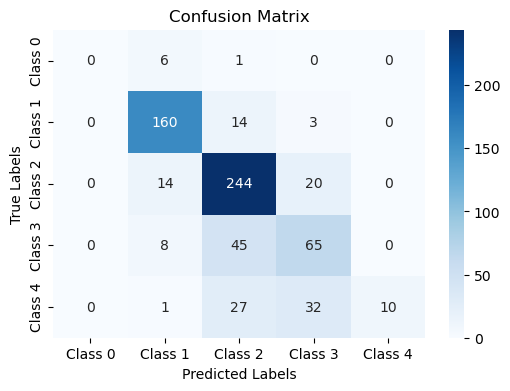

Accuracy: 0.7369230769230769
Precision: 0.6250775268146869
Recall: 0.4950714488941534
F1 Score: 0.4943698112371008
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.85      0.90      0.87       177
           2       0.74      0.88      0.80       278
           3       0.54      0.55      0.55       118
           4       1.00      0.14      0.25        70

    accuracy                           0.74       650
   macro avg       0.63      0.50      0.49       650
weighted avg       0.75      0.74      0.71       650



d:\CodingEnvs\ANACONDA\envs\6893\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\CodingEnvs\ANACONDA\envs\6893\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\CodingEnvs\ANACONDA\envs\6893\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\CodingEnvs\AN

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
conf_matrix = confusion_matrix(true_label, predicted_label)
print(conf_matrix)
# draw confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# 
accuracy = accuracy_score(true_label, predicted_label)
print("Accuracy:", accuracy)

# 
precision = precision_score(true_label, predicted_label, average='macro')
print("Precision:", precision)

# 
recall = recall_score(true_label, predicted_label, average='macro')
print("Recall:", recall)

# 
f1 = f1_score(true_label, predicted_label, average='macro')
print("F1 Score:", f1)

# report
print("Classification Report:")
print(classification_report(true_label, predicted_label))



In [12]:
# test pretrained model, without fine tune
from transformers import BertForSequenceClassification, AutoTokenizer

# set model from huggingface
model_name = "dmis-lab/biobert-base-cased-v1.1"

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 加载 BioBERT 模型，设置分类任务的类别数为 5
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=5)

df = pd.read_csv("1yr_test.csv").head(100)
text = [f"{row['S']} [SEP] {row['A']} [SEP] {row['P']}" for index, row in df.drop(columns=["CDR"]).iterrows()]


encoded_inputs = tokenizer(
    text,
    truncation=True, 
    max_length=512,   
    padding=True,     # padding to maximum length
    return_tensors="pt"  # return pytorch tensor
)

import torch

# test mode
model.eval()

# inference
with torch.no_grad():
    outputs = model(**encoded_inputs)

# get logits
logits = outputs.logits

# get predicted labels
predicted_labels = torch.argmax(logits, dim=1)

print("Predicted labels:", predicted_labels)
label_map = {0: 0, 0.5: 1, 1: 2, 2: 3, 3: 4}
true_labels = [label_map[label] for label in df.CDR.to_list()]
print("true labels",true_labels)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])
true labels [2, 4, 2, 1, 2, 1, 4, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 2, 3, 2, 2, 2, 2, 2, 3, 4, 2, 1, 2, 2, 4, 3, 2, 3, 1, 2, 2, 1, 4, 2, 3, 4, 4, 2, 2, 3, 2, 1, 2, 0, 2, 1, 2, 3, 2, 1, 2, 1, 3, 1, 1, 2, 2, 3, 4, 3, 1, 1, 2, 2, 1, 4, 2, 1, 2, 2, 2, 2, 2, 1, 3, 4, 4, 1, 4, 2, 1, 1, 1, 2, 1, 4, 1, 4, 1, 2, 0, 3, 1, 1]


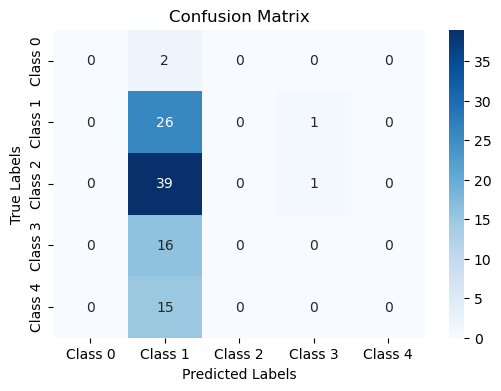

In [13]:
# draw confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()